In [ ]:
# Install all packages
# Restart runtime after installation

#!wget https://github.com/PranjalSahu/ITKThinShellDemons/raw/pranjal_setup/itk_thinshelldemons-0.1.1-cp38-cp38m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
#!pip install itk_thinshelldemons-0.1.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
#!pip install itk_thinshelldemons-0.1.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install itk_thinshelldemons-0.1.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install itk==5.3rc4
!pip install vtk
!pip install itkwidgets

In [8]:
# Import all packages

import numpy as np
#import itkConfig
#itkConfig.LazyLoading = False
import itk
import vtk
import itkwidgets
import math
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
import time
import copy

from vtk.util import numpy_support
from vtk.util.numpy_support import numpy_to_vtk
# To enable itkwidgets window
#from google.colab import output
#output.enable_custom_widget_manager()

In [11]:
# Helper Functions

def subsample_points(inputmesh, mesh_sub_sample_points, seed):
    import vtk
    from vtk.util import numpy_support

    sample = vtk.vtkPolyDataPointSampler()
    sample.SetInputData(inputmesh)
    sample.SetGenerateEdgePoints(0)
    sample.SetGenerateInteriorPoints(0)
    sample.SetPointGenerationModeToRegular()
    sample.SetDistance(0.5)
    sample.Update()

    sampled_points = sample.GetOutput()

    points = sampled_points.GetPoints()
    pointdata = points.GetData()

    as_numpy = numpy_support.vtk_to_numpy(pointdata)
    
    np.random.seed(seed)
    random_indices = np.random.choice(as_numpy.shape[0],
                                      size=mesh_sub_sample_points,
                                      replace=False)
    as_numpy_sampled = as_numpy[random_indices, :]

    return as_numpy_sampled

def subsample_points_poisson(inputMesh):
    import vtk
    from vtk.util import numpy_support

    f = vtk.vtkPoissonDiskSampler()
    f.SetInputData(inputMesh)
    f.SetRadius(4.5)
    f.Update()
    
    sampled_points = f.GetOutput()
    points = sampled_points.GetPoints()
    pointdata = points.GetData()

    as_numpy = numpy_support.vtk_to_numpy(pointdata)
    
    return as_numpy

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

#MOVING_MESH_FILE = '/data/Apedata/CorrectData/data/Pan/meshes/USNM220065-Cranium_merged_1.ply'
#FIXED_MESH_FILE  = '/data/Apedata/CorrectData/data/Gorilla/meshes/USNM252575-Cranium.ply'

# ransac registered
MOVING_MESH_FILE = '/home/pranjal.sahu/Documents/SampleApeData1/USNM174701-Cranium_merged_1.ply'
# original mesh
#MOVING_MESH_FILE = '/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium.ply'

FIXED_MESH_FILE  = '/home/pranjal.sahu/Documents/SampleApeData1/USNM174722-Cranium.ply'

paths = [FIXED_MESH_FILE, MOVING_MESH_FILE]

In [19]:
# Fetch the files

FIXED_MESH_FILE  = r'data/129S1_SVIMJ_.ply'
MOVING_MESH_FILE = r'data/129X1_SVJ_.ply'
paths = [FIXED_MESH_FILE, MOVING_MESH_FILE]

import os
import importlib
from urllib.request import urlretrieve

# Download meshes
os.makedirs('data',exist_ok=True)
if not os.path.exists(FIXED_MESH_FILE):
    url = 'https://github.com/SlicerMorph/Mouse_Models/raw/main/Models/129S1_SVIMJ_.ply'
    urlretrieve(url, FIXED_MESH_FILE)
if not os.path.exists(MOVING_MESH_FILE):
    url = 'https://github.com/SlicerMorph/Mouse_Models/raw/main/Models/129X1_SVJ_.ply'
    urlretrieve(url, MOVING_MESH_FILE)

In [12]:
# Clean the meshes and Triangulate them as TSD only works with Triangle Meshes

vtk_meshes = list()

for path in paths:
    reader = vtk.vtkPLYReader()
    reader.SetFileName(path)
    reader.Update()
        
    cleaner = vtk.vtkCleanPolyData()
    cleaner.SetInputData(reader.GetOutput())
    cleaner.ConvertLinesToPointsOn()
    cleaner.ConvertPolysToLinesOff()
    cleaner.SetTolerance(0.0)
    cleaner.Update()
    vtk_mesh = cleaner.GetOutput()

    triangle_filter = vtk.vtkTriangleFilter()
    triangle_filter.SetInputData(vtk_mesh)
    triangle_filter.SetPassLines(False)
    triangle_filter.SetPassVerts(False)
    triangle_filter.Update()
    vtk_mesh = triangle_filter.GetOutput()
    
    vtk_meshes.append(vtk_mesh)
    
# Write back out to a filetype supported by ITK
vtk_paths = [path.strip('.ply') + '.vtk' for path in paths]
for idx, mesh in enumerate(vtk_meshes):
    writer = vtk.vtkPolyDataWriter()
    writer.SetInputData(mesh)
    writer.SetFileVersion(42)
    writer.SetFileTypeToBinary()
    writer.SetFileName(vtk_paths[idx])
    writer.Update()
    
itk_meshes = [itk.meshread(path, pixel_type=itk.D) for path in vtk_paths]

In [13]:
# Convert meshes to images for performing moment based initialization

itk_transformed_meshes= []
# itk_meshes = []
# itk_meshes.append(itk.meshread('itk_meshes_0.vtk'))
# itk_meshes.append(itk.meshread('itk_meshes_1.vtk'))

itk_images = []
for mesh in itk_meshes:
    # Get all the points to positive values
    temp = itk.array_from_vector_container(mesh.GetPoints())
    m    = np.min(temp, 0)
    temp = temp - m
    mesh.SetPoints(itk.vector_container_from_array(temp.flatten())) 
    
    itk_transformed_meshes.append(mesh)
    itk_image = itk.triangle_mesh_to_binary_image_filter(mesh,
                                                      origin=[0, 0, 0],
                                                      spacing=[1, 1, 1],
                                                      size=[250, 250, 250])
    itk_images.append(itk_image)
                                                         

itk_transforms = list()

for image in itk_images:
    calculator = itk.ImageMomentsCalculator[type(image)].New()
    calculator.SetImage(image)
    calculator.Compute()
    itk_transforms.append(calculator.GetPhysicalAxesToPrincipalAxesTransform())

In [14]:
# Write the Moment based initialized meshes as vtk file

itk_transformed_meshes = [
    itk.transform_mesh_filter(mesh, transform=itk_transforms[idx])
    for idx, mesh in enumerate(itk_meshes)
]

fixedMesh  = itk_meshes[0]#itk_transformed_meshes[0]
movingMesh = itk_meshes[1]#itk_transformed_meshes[1]


w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('movingMesh.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(movingMesh)
w1.Update()

w1 = itk.MeshFileWriter[type(movingMesh)].New()
w1.SetFileName('fixedMesh.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(fixedMesh)
w1.Update()

#itk.meshwrite(movingMesh, 'movingMesh.vtk')
#itk.meshwrite(fixedMesh, 'fixedMesh.vtk')

In [15]:
def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

fixedMesh = readvtk('fixedMesh.vtk')
movingMesh = readvtk('movingMesh.vtk')

In [32]:
# Perform RANSAC ICP

def ransac_icp(fixedMesh, movingMesh, number_of_iterations, mesh_sub_sample_points, number_of_ransac_points, transform_type, convergance_value):
    all_points1 = itk.array_from_vector_container(movingMesh.GetPoints())
    all_points2 = itk.array_from_vector_container(fixedMesh.GetPoints())
    
    # Create Meshes with reduced number of points
    mesh_fixed  = itk.Mesh[itk.D, 3].New()
    mesh_moving = itk.Mesh[itk.D, 3].New()
    
    random_indices = np.random.choice(all_points1.shape[0], size=mesh_sub_sample_points)
    p1 = all_points1[random_indices, :]
    mesh_fixed.SetPoints(itk.vector_container_from_array(p1.flatten()))
    
    random_indices = np.random.choice(all_points2.shape[0], size=mesh_sub_sample_points)
    p2 = all_points2[random_indices, :]
    mesh_moving.SetPoints(itk.vector_container_from_array(p2.flatten()))
    
    best_score = 100000
    best_result = None
    best_transform = None
    
    if transform_type == 0:
        TransformType = itk.Euler3DTransform[itk.D]
    else:
        TransformType = itk.ScaleTransform[itk.D, 3]
    transform = TransformType.New()
    transform.SetIdentity()
    
    e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
    
    # For reproduciblity
    np.random.seed(5)
    for i in range(number_of_iterations):
        random_indices = np.random.choice(all_points1.shape[0], size=number_of_ransac_points)
        p1 = all_points1[random_indices, :]

        random_indices = np.random.choice(all_points2.shape[0], size=number_of_ransac_points)
        p2 = all_points2[random_indices, :]

        ps1 = itk.Mesh[itk.D, 3].New()
        ps2 = itk.Mesh[itk.D, 3].New()

        ps1.SetPoints(itk.vector_container_from_array(p1.flatten()))
        ps2.SetPoints(itk.vector_container_from_array(p2.flatten()))

        MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
        metric = MetricType.New()
        metric.SetMovingPointSet(ps2)
        metric.SetFixedPointSet(ps1)
        metric.SetMovingTransform(transform)
        metric.Initialize()

        optimizer = itk.ConjugateGradientLineSearchOptimizerv4Template[itk.D].New()
        optimizer.SetNumberOfIterations(10)
        optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
        optimizer.SetMinimumConvergenceValue( 0.0 )
        optimizer.SetConvergenceWindowSize( 10 )
        optimizer.SetMetric(metric)
        optimizer.StartOptimization()

        current_transform    = metric.GetTransform()
        itk_transformed_mesh = itk.transform_mesh_filter(mesh_moving, transform=current_transform)

        e_metric.SetFixedPointSet(mesh_fixed)
        e_metric.SetMovingPointSet(itk_transformed_mesh)
        e_metric.Initialize()

        current_value = e_metric.GetValue()
        
        if current_value < best_score:
            best_score     = current_value
            best_result    = itk_transformed_mesh
            best_transform = current_transform

        if convergance_value > 0 and best_score < convergance_value:
            break
    
    print('Best Score ', best_score)
    itk_transformed_mesh = itk.transform_mesh_filter(movingMesh, transform=best_transform)
    return itk_transformed_mesh


#movingMesh = itk.meshread('/data/Apedata/apedata/apes/models/gorilla/USNM252577-Cranium.vtk')
#fixedMesh  = itk.meshread('/data/Apedata/apedata/apes/models/orangutan/USNM145303-Cranium.vtk')

movingMesh = itk.meshread('movingMesh.vtk')
fixedMesh  = itk.meshread('fixedMesh.vtk')

number_of_iterations    = 2000
number_of_ransac_points = 250
mesh_sub_sample_points  = 5000
convergence_value       = 6
transform_type          = 0

import time
start_time = time.time()
itk_transformed_mesh = ransac_icp(fixedMesh, movingMesh, number_of_iterations, mesh_sub_sample_points, number_of_ransac_points, transform_type, convergence_value)
itk.meshwrite(itk_transformed_mesh, 'ransacICPResult1.vtk')
end_time = time.time()

print(end_time - start_time)
# itk_transformed_mesh = itk.meshread('ransacICPResult1.vtk')
# number_of_iterations    = 100
# number_of_ransac_points = 1000
# mesh_sub_sample_points  = 20000
# convergence_value       = -1
# transform_type          = 0
# itk_transformed_mesh = ransac_icp(fixedMesh, itk_transformed_mesh, number_of_iterations, mesh_sub_sample_points, number_of_ransac_points, transform_type, convergence_value)
# itk.meshwrite(itk_transformed_mesh, 'ransacICPResult2.vtk')


# number_of_iterations    = 100
# number_of_ransac_points = 10000
# mesh_sub_sample_points  = 20000
# convergence_value       = -1
# transform_type          = 1
# itk_transformed_mesh = ransac_icp(fixedMesh, itk_transformed_mesh, number_of_iterations, mesh_sub_sample_points, number_of_ransac_points, transform_type, convergence_value)
# itk.meshwrite(itk_transformed_mesh, 'ransacICPResult3.vtk')

Best Score  13.128441318309916
65.535471200943


In [ ]:
# Perform Scale Transform

mesh_sub_sample_points = 10000

fixedMesh  = itk.meshread('fixedMesh.vtk', itk.D)
movingMesh = itk.meshread('movingMesh.vtk', itk.D)

ps1 = itk.Mesh[itk.D, 3].New()
ps2 = itk.Mesh[itk.D, 3].New()

all_points1 = itk.array_from_vector_container(fixedMesh.GetPoints())
all_points2 = itk.array_from_vector_container(movingMesh.GetPoints())

random_indices = np.random.choice(all_points1.shape[0], size=mesh_sub_sample_points)
p1 = all_points1[random_indices, :]

random_indices = np.random.choice(all_points2.shape[0], size=mesh_sub_sample_points)
p2 = all_points2[random_indices, :]

ps1.SetPoints(itk.vector_container_from_array(p1.flatten()))
ps2.SetPoints(itk.vector_container_from_array(p2.flatten()))


    
TransformType = itk.ScaleTransform[itk.D, 3]
        
transform = TransformType.New()
transform.SetIdentity()

MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
metric = MetricType.New()
metric.SetMovingPointSet(movingMesh)
metric.SetFixedPointSet(fixedMesh)
metric.SetMovingTransform(transform)
metric.Initialize()

optimizer = itk.ConjugateGradientLineSearchOptimizerv4Template[itk.D].New()
optimizer.SetNumberOfIterations(10)
optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
optimizer.SetMinimumConvergenceValue( 0.0 )
optimizer.SetConvergenceWindowSize( 10 )
optimizer.SetMetric(metric)
optimizer.StartOptimization()

current_transform    = metric.GetTransform()
itk_transformed_mesh = itk.transform_mesh_filter(movingMesh, transform=current_transform)

In [52]:
# For performing RANSAC in parallel

from vtk.util import numpy_support
from vtk.util.numpy_support import numpy_to_vtk


def ransac_icp_parallel(fixedMeshPoints, movingMeshPoints, movingMeshAllPoints,
                        number_of_iterations, mesh_sub_sample_points,
                        number_of_ransac_points, transform_type,
                        convergance_value):
    import numpy as np
    np.random.seed(0)

    all_points1 = fixedMeshPoints
    all_points2 = movingMeshPoints

    def process(i, mesh_sub_sample_points, number_of_ransac_points,
                return_result):
        # Create Mesh inside the method to tackle the problem of serialization
        
        import itk
        
        mesh_fixed = itk.Mesh[itk.D, 3].New()
        mesh_moving = itk.Mesh[itk.D, 3].New()

        mesh_fixed.SetPoints(
            itk.vector_container_from_array(all_points1.flatten()))
        mesh_moving.SetPoints(
            itk.vector_container_from_array(all_points2.flatten()))

        ps1 = itk.Mesh[itk.D, 3].New()
        ps2 = itk.Mesh[itk.D, 3].New()
        
        
        # Create small point sets
        np.random.seed(i)
        random_indices = np.random.choice(all_points1.shape[0],
                                          size=number_of_ransac_points)
        p1_a = all_points1[random_indices, :]

        random_indices = np.random.choice(all_points2.shape[0],
                                          size=number_of_ransac_points)
        p2_a = all_points2[random_indices, :]

        ps1.SetPoints(itk.vector_container_from_array(p1_a.flatten()))
        ps2.SetPoints(itk.vector_container_from_array(p2_a.flatten()))

        if transform_type == 0:
            TransformType = itk.Euler3DTransform[itk.D]
        elif transform_type == 1:
            TransformType = itk.ScaleVersor3DTransform[itk.D]
        elif transform_type == 2:
            TransformType = itk.Similarity3DTransform[itk.D]
        else:
            TransformType = itk.AffineTransform[itk.D, 3]

        transform = TransformType.New()
        transform.SetIdentity()
        
        MetricType = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3
        metric = MetricType.New()
        metric.SetMovingPointSet(ps2)
        metric.SetFixedPointSet(ps1)
        metric.SetMovingTransform(transform)
        metric.Initialize()
                
        optimizer = itk.ConjugateGradientLineSearchOptimizerv4Template[itk.D].New()
        optimizer.SetNumberOfIterations(20)
        optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
        optimizer.SetMinimumConvergenceValue( 0.0 )
        optimizer.SetConvergenceWindowSize( 20 )
        optimizer.SetMetric(metric)
        optimizer.StartOptimization()

        """
        optimizer = itk.GradientDescentOptimizerv4Template.D.New()
        optimizer.SetNumberOfIterations(200)
        optimizer.SetLearningRate(0.1)
        optimizer.SetMaximumStepSizeInPhysicalUnits( 0.1 )
        optimizer.SetMinimumConvergenceValue( 0.0 )
        optimizer.SetConvergenceWindowSize( 200 )
        optimizer.SetMetric(metric)
        optimizer.StartOptimization()
        """
        
        current_transform = metric.GetTransform()
        itk_transformed_mesh = itk.transform_mesh_filter(
            mesh_moving, transform=current_transform)

        e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
        e_metric.SetFixedPointSet(mesh_fixed)
        e_metric.SetMovingPointSet(itk_transformed_mesh)
        e_metric.Initialize()

        current_value = e_metric.GetValue()
        #current_transform = itk.dict_from_transform(current_transform)

        if return_result:
            mesh_moving = itk.Mesh[itk.D, 3].New()
            mesh_moving.SetPoints(
                itk.vector_container_from_array(movingMeshAllPoints.flatten()))
            
            itk_transformed_mesh = itk.transform_mesh_filter(
                mesh_moving, transform=current_transform)
            
            return itk.array_from_vector_container(
                itk_transformed_mesh.GetPoints())
        else:
            return (current_value, i)
        #if current_value < 7:
        #    return (current_value, i)
        #else:
        #    return (current_value, -1)

    results = Parallel(n_jobs=8)(
        delayed(process)(i, mesh_sub_sample_points, number_of_ransac_points, 0)
        for i in range(number_of_iterations))
    results = sorted(results)

    print(results[0])
    final_result = process(results[0][1], mesh_sub_sample_points,
                           number_of_ransac_points, 1)
    #movingMesh.SetPoints(itk.vector_container_from_array(final_result.flatten()))
    
    return final_result

import time

number_of_iterations = 2500
number_of_ransac_points = 100
mesh_sub_sample_points = 5000
convergence_value = 3
transform_type = 2

movingMesh = readvtk('movingMesh.vtk')
fixedMesh  = readvtk('fixedMesh.vtk')

movingMeshAllPoints = numpy_support.vtk_to_numpy(
    movingMesh.GetPoints().GetData())

movingMeshPoints = subsample_points_poisson(movingMesh)
fixedMeshPoints  = subsample_points_poisson(fixedMesh)

print(movingMeshPoints.shape, type(movingMeshPoints), movingMeshPoints.dtype)
print(fixedMeshPoints.shape)
print(movingMeshAllPoints.shape)

def get_bounding_box_data(inputMeshPoints):
    ElementIdentifierType = itk.UL
    CoordType = itk.F
    Dimension = 3

    VecContType = itk.VectorContainer[
        ElementIdentifierType, itk.Point[CoordType, Dimension]
    ]

    ps = itk.PointSet.D3.New()
    ps.SetPoints(itk.vector_container_from_array(inputMeshPoints.flatten()))

    bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType, VecContType].New()
    bounding_box.SetPoints(ps.GetPoints())
    bounding_box.ComputeBoundingBox()

    minBounds = np.array(bounding_box.GetMinimum())
    maxBounds = np.array(bounding_box.GetMaximum())
    
    return maxBounds - minBounds, bounding_box.GetCenter()

def perform_scaling(movingMeshPoints, fixedMeshPoints):
    md1, cm1 = get_bounding_box_data(movingMeshPoints)
    fd1, cf1 = get_bounding_box_data(fixedMeshPoints)
    
    transform = itk.ScaleTransform.D3.New()
    transform.SetScale([fd1[0]/md1[0], fd1[1]/md1[1], fd1[2]/md1[2]])
    transform.SetCenter(cm1)

    ps = itk.Mesh.D3.New()
    ps.SetPoints(itk.vector_container_from_array(movingMeshPoints.flatten()))

    scaledMovingMeshPoints = itk.transform_mesh_filter(ps, transform=transform)
    scaledMovingMeshPoints = itk.array_from_vector_container(scaledMovingMeshPoints.GetPoints())
    scaledMovingMeshPoints = scaledMovingMeshPoints - cm1 + cf1
    return scaledMovingMeshPoints

movingMeshPoints = perform_scaling(movingMeshPoints, fixedMeshPoints)


# start_time = time.time()
# itk_transformed_points = ransac_icp_parallel(fixedMeshPoints, movingMeshPoints,
#                                              movingMeshAllPoints,
#                                              number_of_iterations,
#                                              mesh_sub_sample_points,
#                                              number_of_ransac_points,
#                                              transform_type, convergence_value)
# end_time = time.time()

# print(end_time - start_time)
# print('itk_transformed_points shape ', itk_transformed_points.shape)

# itk_transformed_mesh = itk.meshread('movingMesh.vtk')

# #itk_transformed_mesh = itk.Mesh.D3.New()
# itk_transformed_mesh.SetPoints(
#     itk.vector_container_from_array(itk_transformed_points.flatten()))

# w1 = itk.MeshFileWriter[type(itk_transformed_mesh)].New()
# w1.SetFileName('ransacICPResult2_b.vtk')
# w1.SetFileTypeAsBINARY()
# w1.SetInput(itk_transformed_mesh)
# w1.Update()

(3754, 3) <class 'numpy.ndarray'> float32
(8002, 3)
(2209640, 3)


In [ ]:
# Findings
# Optimizing with Similarity transform which has both scale and rotation is slower.
# Better to perform re-sacling first and then performing the optimization.

In [22]:
# Visualize the results after RANSAC ICP

from itkwidgets import view

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

#m1 = readvtk('fixedMesh.vtk')
#m2 = readvtk('movingMesh.vtk')
#m3 = readvtk('ransacICPResult1_b.vtk')
#m4 = readvtk('ransacICPResult1_c.vtk')


#m1 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.vtk')
#m2 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.vtk')

m1 = readvtk('fixedMesh.vtk')
m2 = readvtk('movingMesh.vtk')
m3 = readvtk('ransacICPResult2_b.vtk')
#m3 = readply('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.ply')
#m4 = readvtk('ransacICPResult2_b.vtk')


#m1 = readvtk('/home/pranjal.sahu/Documents/TargetPointcloud.vtk')
#m2 = readvtk('/home/pranjal.sahu/Documents/SourcePointcloud.vtk')

#m1 = readply('USNM252577-Cranium_8.ply')
#m2 = readply('USNM145303-Cranium_9.ply')
#m3 = readply('/data/Apedata/apedata/apes/models/orangutan/USNM145303-Cranium.ply')

#m3 = readvtk('ransacICPResult2.vtk')
#m4 = readvtk('ransacICPResult2.vtk')
#m4 = readvtk('ransacICPResult2.vtk')

#m1 = readply('/data/Apedata/apedata/experiment/USNM145303-Cranium_1.ply')
#m2 = readply('/data/Apedata/apedata/experiment/USNM252577-Cranium.ply')
#m3 = readvtk('/data/Apedata/apedata/experiment/WarpedSourceMesh.vtk')

#print(m1.GetNumberOfPoints())
#print(m2.GetNumberOfPoints())
#print(m3.GetNumberOfPoints())
#print(m4.GetNumberOfPoints())

#view(point_sets=[movingMeshPoints, fixedMeshPoints])
#view(geometries=[m1, m2, m4])
#view(geometries=[m1, m2, m3, m4])
#view(geometries=[m1, m2, m3])
view(geometries=[m1, m2, m3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
#itkwidgets.view(point_sets=[movingMeshPoints_uniform, movingMeshPoints_random])
itkwidgets.view(point_sets=[movingMeshPoints_random, vtp_points])

In [6]:
mesh_fixed = itk.Mesh.D3.New()#itk.meshread('fixedMesh.vtk', itk.D)
itk_transformed_mesh = itk.Mesh.D3.New()#itk.meshread('ransacICPResult2_b.vtk', itk.D)

mesh_fixed.SetPoints(itk.vector_container_from_array(fixedMeshPoints.flatten()))
itk_transformed_mesh.SetPoints(itk.vector_container_from_array(itk_transformed_points.flatten()))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(mesh_fixed)
e_metric.SetMovingPointSet(itk_transformed_mesh)
e_metric.Initialize()

print(e_metric.GetValue())

5.559841893722685


In [16]:
# [STAR] Expectation Based PointSetToPointSetMetricv4 Registration

import copy
from vtk.util import numpy_support

imageDiagonal = 100

PixelType = itk.D
Dimension = 3


mesh_sub_sample_points = 5000
convergence_value = 3
transform_type = 2


FixedImageType = itk.Image[PixelType, Dimension]

#fixedMeshPath  = '/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.vtk'
fixedMeshPath  = 'fixedMesh.vtk'
movingMeshPath = 'ransacICPResult2_b.vtk'
#movingMeshPath = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.vtk')

# Read the meshes
fixedMesh  = readvtk(fixedMeshPath)
movingMesh = readvtk(movingMeshPath)


movingMeshAllPoints = copy.deepcopy(numpy_support.vtk_to_numpy(
    movingMesh.GetPoints().GetData()))

fixedMeshAllPoints = copy.deepcopy(numpy_support.vtk_to_numpy(
    fixedMesh.GetPoints().GetData()))

print(movingMeshAllPoints.shape)
print(fixedMeshAllPoints.shape)

movingMeshPoints = subsample_points_poisson(movingMesh)
fixedMeshPoints = subsample_points_poisson(fixedMesh)

print(movingMeshPoints.shape)
print(fixedMeshPoints.shape)



# Create PointSets for registration
movingPS = itk.PointSet[itk.D, Dimension].New()
fixedPS = itk.PointSet[itk.D, Dimension].New()

movingPS.SetPoints(itk.vector_container_from_array(movingMeshPoints.flatten()))
fixedPS.SetPoints(itk.vector_container_from_array(fixedMeshPoints.flatten()))



# For getting the Bounding Box
ElementIdentifierType = itk.UL
CoordType = itk.F
Dimension = 3

VecContType = itk.VectorContainer[ElementIdentifierType, itk.Point[CoordType,
                                                                   Dimension]]
bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType,
                               VecContType].New()

#all_points = np.concatenate([itk.array_from_vector_container(movingPS.GetPoints()), itk.array_from_vector_container(movingPS.GetPoints())])

bounding_box.SetPoints(fixedPS.GetPoints())
bounding_box.ComputeBoundingBox()

minBounds = np.array(bounding_box.GetMinimum())
maxBounds = np.array(bounding_box.GetMaximum())

spacing = np.sqrt(bounding_box.GetDiagonalLength2()) / imageDiagonal
diff = maxBounds - minBounds

print('Spacing ', spacing)
print('minBounds ', minBounds)
print('maxBounds ', maxBounds)

fixedImageSize = [0] * 3
fixedImageSize[0] = math.ceil(1.25 * diff[0] / spacing)
fixedImageSize[1] = math.ceil(1.25 * diff[1] / spacing)
fixedImageSize[2] = math.ceil(1.25 * diff[2] / spacing)

fixedImageOrigin = [0] * 3
fixedImageOrigin[0] = minBounds[0] - 0.25 * diff[0]
fixedImageOrigin[1] = minBounds[1] - 0.25 * diff[1]
fixedImageOrigin[2] = minBounds[2] - 0.25 * diff[2]

fixedImageSpacing = np.ones(3) * spacing
fixedImageDirection = np.identity(3)

fixedImage = FixedImageType.New()
fixedImage.SetRegions(fixedImageSize)
fixedImage.SetOrigin(fixedImageOrigin)
fixedImage.SetDirection(fixedImageDirection)
fixedImage.SetSpacing(fixedImageSpacing)
fixedImage.Allocate()



# Create BSpline Transformation object and initialize the parameters
SplineOrder = 3
TransformType = itk.BSplineTransform[itk.D, Dimension, SplineOrder]
InitializerType = itk.BSplineTransformInitializer[TransformType,
                                                  FixedImageType]

transform = TransformType.New()

# Higher the grid dimensio, slower the computation but higher will be the accuracy
# Increasing the grid nodes is not working
numberOfGridNodesInOneDimension = 8
transformInitializer = InitializerType.New()
transformInitializer.SetTransform(transform)
transformInitializer.SetImage(fixedImage)
transformInitializer.SetTransformDomainMeshSize(
    numberOfGridNodesInOneDimension - SplineOrder)
transformInitializer.InitializeTransform()



# Registration Loop
numOfIterations = 10000
maxStep = 0.1
learningRate = 0.1

MetricType = itk.ExpectationBasedPointSetToPointSetMetricv4[type(movingPS)]
metric = MetricType.New()
metric.SetFixedPointSet(movingPS)
metric.SetMovingPointSet(fixedPS)
metric.SetPointSetSigma(1)
metric.SetEvaluationKNeighborhood(10)
metric.SetMovingTransform(transform)
metric.Initialize()

print('Metric Created')

optimizer = itk.RegularStepGradientDescentOptimizerv4.D.New()
optimizer.SetNumberOfIterations(numOfIterations)
optimizer.SetMaximumStepSizeInPhysicalUnits(maxStep)
optimizer.SetLearningRate(learningRate)
optimizer.SetMinimumConvergenceValue(-100)
optimizer.SetConvergenceWindowSize(numOfIterations)
optimizer.SetMetric(metric)

def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")


iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)

optimizer.StartOptimization()


# Transform the point set using the final transform
final_transform = metric.GetMovingTransform()

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedPS)
e_metric.SetMovingPointSet(movingPS)
print('Euclidean Metric Before TSD Deformable Registration ', e_metric.GetValue())

numberOfPoints = movingPS.GetNumberOfPoints()
for n in range(0, numberOfPoints):
    movingPS.SetPoint(n, final_transform.TransformPoint(movingPS.GetPoint(n)))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedPS)
e_metric.SetMovingPointSet(movingPS)
print('Euclidean Metric After TSD Deformable Registration ', e_metric.GetValue())


# Write the mesh to disk
movingMeshITK = itk.meshread(movingMeshPath, itk.D)
numberOfPoints = movingMeshITK.GetNumberOfPoints()
for n in range(0, numberOfPoints):
    movingMeshITK.SetPoint(n, final_transform.TransformPoint(movingMeshITK.GetPoint(n)))
    

w1 = itk.MeshFileWriter[type(movingMeshITK)].New()
w1.SetFileName('ransacICPResult2_c_check.vtk')
w1.SetFileTypeAsBINARY()
w1.SetInput(movingMeshITK)
w1.Update()

# Write the Displacement Field

convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(final_transform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

(3277652, 3)
(2209640, 3)
(3960, 3)
(3754, 3)
Spacing  2.4060874133383017
minBounds  [0.30308533 1.24621582 1.60623169]
maxBounds  [122.26802063 180.34346008 106.20689392]
Metric Created
Metric: -0.019899586
Metric: -0.019898511
Metric: -0.01989748
Metric: -0.019896437
Metric: -0.01989529
Metric: -0.019894586
Metric: -0.019894192
Metric: -0.019893661
Metric: -0.019892567
Metric: -0.019890461
Metric: -0.019887255
Metric: -0.019884198
Metric: -0.019882917
Metric: -0.0198834
Metric: -0.01988525
Metric: -0.019888067
Metric: -0.019891368
Metric: -0.019895134
Metric: -0.019899386
Metric: -0.019904143
Metric: -0.019909482
Metric: -0.019915494
Metric: -0.019922344
Metric: -0.019930124
Metric: -0.019938904
Metric: -0.019948467
Metric: -0.019958565
Metric: -0.019968952
Metric: -0.019979386
Metric: -0.019989836
Metric: -0.020000096
Metric: -0.020010262
Metric: -0.020020085
Metric: -0.020029743
Metric: -0.020038912
Metric: -0.020047904
Metric: -0.020056205
Metric: -0.020064373
Metric: -0.020071583

Metric: -0.021183915
Metric: -0.021197458
Metric: -0.021211176
Metric: -0.021225014
Metric: -0.021238928
Metric: -0.021252895
Metric: -0.021266896
Metric: -0.021280915
Metric: -0.021294942
Metric: -0.021308972
Metric: -0.021322997
Metric: -0.021337027
Metric: -0.021351057
Metric: -0.021365074
Metric: -0.021379095
Metric: -0.021393106
Metric: -0.021407097
Metric: -0.021421056
Metric: -0.021434958
Metric: -0.021448786
Metric: -0.021462498
Metric: -0.021476054
Metric: -0.021489412
Metric: -0.021502505
Metric: -0.021515275
Metric: -0.021527662
Metric: -0.021539609
Metric: -0.021551043
Metric: -0.02156192
Metric: -0.021572213
Metric: -0.021581904
Metric: -0.021592242
Metric: -0.021601705
Metric: -0.021610353
Metric: -0.021618314
Metric: -0.021625765
Metric: -0.021632845
Metric: -0.021639709
Metric: -0.021646509
Metric: -0.021653458
Metric: -0.021660777
Metric: -0.021668526
Metric: -0.021676501
Metric: -0.021684378
Metric: -0.021691985
Metric: -0.02169924
Metric: -0.021706136
Metric: -0.0217

Metric: -0.022439215
Metric: -0.022442286
Metric: -0.022444897
Metric: -0.02244699
Metric: -0.022448475
Metric: -0.022449343
Metric: -0.022449598
Metric: -0.022449256
Metric: -0.02244842
Metric: -0.022447218
Metric: -0.022445846
Metric: -0.022444445
Metric: -0.022443115
Metric: -0.022441859
Metric: -0.022440703
Metric: -0.022439534
Metric: -0.022438341
Metric: -0.022436937
Metric: -0.022435314
Metric: -0.022433009
Metric: -0.02243041
Metric: -0.022426173
Metric: -0.022423063
Metric: -0.022416034
Metric: -0.022416019
Metric: -0.022407704
Metric: -0.022408277
Metric: -0.022404601
Metric: -0.022401201
Metric: -0.022397498
Metric: -0.022393822
Metric: -0.022390057
Metric: -0.022386303
Metric: -0.022382512
Metric: -0.022378719
Metric: -0.022374978
Metric: -0.022371305
Metric: -0.022367738
Metric: -0.022364319
Metric: -0.022361081
Metric: -0.022358078
Metric: -0.02235536
Metric: -0.022352996
Metric: -0.022351015
Metric: -0.022349447
Metric: -0.022348263
Metric: -0.022347643
Metric: -0.022347

Metric: -0.022735883
Metric: -0.02273783
Metric: -0.022739781
Metric: -0.022741751
Metric: -0.022743741
Metric: -0.022745765
Metric: -0.022747835
Metric: -0.022749972
Metric: -0.022752166
Metric: -0.022754438
Metric: -0.022756797
Metric: -0.022759248
Metric: -0.022761802
Metric: -0.022764448
Metric: -0.022767192
Metric: -0.022770044
Metric: -0.022772978
Metric: -0.022775988
Metric: -0.022779069
Metric: -0.022782209
Metric: -0.02278538
Metric: -0.022788587
Metric: -0.022791816
Metric: -0.022795069
Metric: -0.022798325
Metric: -0.022801575
Metric: -0.022804814
Metric: -0.02280804
Metric: -0.022811231
Metric: -0.022814389
Metric: -0.022817498
Metric: -0.022820549
Metric: -0.022823524
Metric: -0.02282641
Metric: -0.022829195
Metric: -0.022831865
Metric: -0.022834401
Metric: -0.022836804
Metric: -0.022839056
Metric: -0.022841168
Metric: -0.02284313
Metric: -0.022844955
Metric: -0.02284665
Metric: -0.022848221
Metric: -0.022849682
Metric: -0.022851038
Metric: -0.022852303
Metric: -0.02285348

Metric: -0.023190729
Metric: -0.023188628
Metric: -0.023186556
Metric: -0.023184512
Metric: -0.023182509
Metric: -0.023180548
Metric: -0.023178616
Metric: -0.023176729
Metric: -0.023174885
Metric: -0.023173077
Metric: -0.023171317
Metric: -0.023169585
Metric: -0.023167891
Metric: -0.023166236
Metric: -0.023164613
Metric: -0.023163023
Metric: -0.023161455
Metric: -0.023159916
Metric: -0.023158472
Metric: -0.023157086
Metric: -0.023155739
Metric: -0.023154427
Metric: -0.023153154
Metric: -0.023151905
Metric: -0.023150682
Metric: -0.02314949
Metric: -0.023148323
Metric: -0.023147186
Metric: -0.023146081
Metric: -0.023145011
Metric: -0.02314399
Metric: -0.023143018
Metric: -0.023142097
Metric: -0.023141256
Metric: -0.023140478
Metric: -0.023139793
Metric: -0.023139187
Metric: -0.023138667
Metric: -0.023138257
Metric: -0.023137931
Metric: -0.023137699
Metric: -0.023137557
Metric: -0.023137515
Metric: -0.023144065
Metric: -0.023150637
Metric: -0.023157248
Metric: -0.023163909
Metric: -0.0231

Metric: -0.024700942
Metric: -0.024702677
Metric: -0.024704378
Metric: -0.02470605
Metric: -0.024707769
Metric: -0.024709473
Metric: -0.024711157
Metric: -0.024712836
Metric: -0.024714517
Metric: -0.024716203
Metric: -0.024717886
Metric: -0.024719569
Metric: -0.024721251
Metric: -0.024722926
Metric: -0.024724594
Metric: -0.024726249
Metric: -0.024727897
Metric: -0.024729524
Metric: -0.024731145
Metric: -0.024732748
Metric: -0.024734346
Metric: -0.02473594
Metric: -0.024737529
Metric: -0.024739118
Metric: -0.024740717
Metric: -0.024742301
Metric: -0.0247439
Metric: -0.024745503
Metric: -0.024747111
Metric: -0.024748707
Metric: -0.024750312
Metric: -0.024751895
Metric: -0.024753464
Metric: -0.024755005
Metric: -0.024756506
Metric: -0.024757969
Metric: -0.024759351
Metric: -0.024760656
Metric: -0.024761846
Metric: -0.024762908
Metric: -0.024763802
Metric: -0.024764502
Metric: -0.024764983
Metric: -0.024765235
Metric: -0.02476524
Metric: -0.024764999
Metric: -0.02476453
Metric: -0.02476389

Metric: -0.025363012
Metric: -0.02536109
Metric: -0.025359201
Metric: -0.02535735
Metric: -0.025355538
Metric: -0.025353766
Metric: -0.025352052
Metric: -0.025350378
Metric: -0.02534874
Metric: -0.02534713
Metric: -0.025345547
Metric: -0.025343987
Metric: -0.025342451
Metric: -0.025340933
Metric: -0.025339419
Metric: -0.025337918
Metric: -0.025336416
Metric: -0.025334916
Metric: -0.025333408
Metric: -0.02533189
Metric: -0.025330363
Metric: -0.025328815
Metric: -0.025327254
Metric: -0.02532567
Metric: -0.025324056
Metric: -0.025322428
Metric: -0.025320765
Metric: -0.025319086
Metric: -0.025317382
Metric: -0.025315646
Metric: -0.025313893
Metric: -0.025312118
Metric: -0.025310332
Metric: -0.025308531
Metric: -0.025306715
Metric: -0.025304896
Metric: -0.02530308
Metric: -0.025301271
Metric: -0.025299455
Metric: -0.025297658
Metric: -0.025295889
Metric: -0.025294144
Metric: -0.025292436
Metric: -0.025290765
Metric: -0.02528914
Metric: -0.025287565
Metric: -0.025286043
Metric: -0.02528459
M

Metric: -0.025308902
Metric: -0.025310414
Metric: -0.025311913
Metric: -0.025313412
Metric: -0.025314922
Metric: -0.025316443
Metric: -0.025317972
Metric: -0.025319502
Metric: -0.025321041
Metric: -0.025322598
Metric: -0.025324157
Metric: -0.02532573
Metric: -0.025327306
Metric: -0.0253289
Metric: -0.025330503
Metric: -0.025332108
Metric: -0.025333727
Metric: -0.025335352
Metric: -0.025336993
Metric: -0.025338642
Metric: -0.025340297
Metric: -0.025341966
Metric: -0.025343638
Metric: -0.025345316
Metric: -0.025346989
Metric: -0.025348684
Metric: -0.025350375
Metric: -0.025352064
Metric: -0.025353753
Metric: -0.025355436
Metric: -0.025357122
Metric: -0.025358805
Metric: -0.025360474
Metric: -0.025362145
Metric: -0.025363803
Metric: -0.025365464
Metric: -0.025367118
Metric: -0.025368771
Metric: -0.025370426
Metric: -0.025372101
Metric: -0.025373788
Metric: -0.025375495
Metric: -0.025377231
Metric: -0.02537902
Metric: -0.02538087
Metric: -0.025382796
Metric: -0.025384809
Metric: -0.0253869

Metric: -0.026908928
Metric: -0.026918829
Metric: -0.026928199
Metric: -0.026936994
Metric: -0.026945242
Metric: -0.026952985
Metric: -0.026960268
Metric: -0.026967121
Metric: -0.02697351
Metric: -0.026979395
Metric: -0.026984659
Metric: -0.026989201
Metric: -0.026992914
Metric: -0.026995804
Metric: -0.026997962
Metric: -0.026999584
Metric: -0.027000882
Metric: -0.027002057
Metric: -0.027003281
Metric: -0.02700467
Metric: -0.027006325
Metric: -0.027008304
Metric: -0.027010677
Metric: -0.027013444
Metric: -0.02701661
Metric: -0.027020178
Metric: -0.027024091
Metric: -0.027028314
Metric: -0.027032812
Metric: -0.027037518
Metric: -0.027042406
Metric: -0.027047422
Metric: -0.027052523
Metric: -0.0270577
Metric: -0.027062938
Metric: -0.027068215
Metric: -0.027073514
Metric: -0.027078821
Metric: -0.027084131
Metric: -0.027089432
Metric: -0.027094723
Metric: -0.027099994
Metric: -0.027105243
Metric: -0.027110459
Metric: -0.02711565
Metric: -0.02712081
Metric: -0.027125944
Metric: -0.027131037

Metric: -0.028377081
Metric: -0.028379807
Metric: -0.028382509
Metric: -0.028385171
Metric: -0.028387805
Metric: -0.028390398
Metric: -0.028392949
Metric: -0.02839546
Metric: -0.02839792
Metric: -0.028400334
Metric: -0.028402687
Metric: -0.028405001
Metric: -0.028407244
Metric: -0.028409434
Metric: -0.028411558
Metric: -0.028413631
Metric: -0.028415637
Metric: -0.028417577
Metric: -0.028419452
Metric: -0.028421258
Metric: -0.028422978
Metric: -0.028424635
Metric: -0.028426208
Metric: -0.028427707
Metric: -0.028429127
Metric: -0.028430458
Metric: -0.02843171
Metric: -0.028432872
Metric: -0.028433953
Metric: -0.028434967
Metric: -0.028435895
Metric: -0.02843674
Metric: -0.028437502
Metric: -0.028438184
Metric: -0.028438793
Metric: -0.028439315
Metric: -0.028439773
Metric: -0.028440158
Metric: -0.028440474
Metric: -0.028440733
Metric: -0.028440926
Metric: -0.028441055
Metric: -0.028441151
Metric: -0.028441191
Metric: -0.028441183
Metric: -0.028441132
Metric: -0.028441033
Metric: -0.028440

Metric: -0.028964333
Metric: -0.028964992
Metric: -0.028965671
Metric: -0.028966361
Metric: -0.028967072
Metric: -0.028967794
Metric: -0.028968552
Metric: -0.028969328
Metric: -0.028970135
Metric: -0.028970969
Metric: -0.028971851
Metric: -0.02897276
Metric: -0.028973711
Metric: -0.02897471
Metric: -0.028975751
Metric: -0.028976844
Metric: -0.028977975
Metric: -0.028979152
Metric: -0.028980376
Metric: -0.028981637
Metric: -0.028982923
Metric: -0.028984241
Metric: -0.02898557
Metric: -0.028986909
Metric: -0.028988246
Metric: -0.02898956
Metric: -0.028990851
Metric: -0.028992101
Metric: -0.028993297
Metric: -0.02899442
Metric: -0.028995459
Metric: -0.028996412
Metric: -0.028997252
Metric: -0.028997921
Metric: -0.028998476
Metric: -0.028998893
Metric: -0.028999155
Metric: -0.028999268
Metric: -0.028999205
Metric: -0.02899897
Metric: -0.028998544
Metric: -0.02899791
Metric: -0.028997075
Metric: -0.028996004
Metric: -0.0289947
Metric: -0.028993149
Metric: -0.02899135
Metric: -0.028989285
Me

Metric: -0.029002365
Metric: -0.029004341
Metric: -0.029006331
Metric: -0.029008333
Metric: -0.029010346
Metric: -0.029012359
Metric: -0.029014378
Metric: -0.029016402
Metric: -0.029018433
Metric: -0.029020466
Metric: -0.0290225
Metric: -0.029024541
Metric: -0.029026577
Metric: -0.029028604
Metric: -0.029030642
Metric: -0.029032678
Metric: -0.029034708
Metric: -0.029036743
Metric: -0.029038765
Metric: -0.029040794
Metric: -0.029042826
Metric: -0.029044848
Metric: -0.029046871
Metric: -0.029048894
Metric: -0.02905091
Metric: -0.029052928
Metric: -0.029054951
Metric: -0.029056967
Metric: -0.029058983
Metric: -0.029061002
Metric: -0.02906302
Metric: -0.029065039
Metric: -0.029067056
Metric: -0.029069074
Metric: -0.029071095
Metric: -0.029073112
Metric: -0.029075133
Metric: -0.029077157
Metric: -0.029079178
Metric: -0.029081202
Metric: -0.029083227
Metric: -0.029085258
Metric: -0.029087281
Metric: -0.02908931
Metric: -0.029091338
Metric: -0.029093362
Metric: -0.029095385
Metric: -0.0290974

Metric: -0.029483931
Metric: -0.029485804
Metric: -0.029487679
Metric: -0.029489545
Metric: -0.029491421
Metric: -0.029493288
Metric: -0.029495154
Metric: -0.029497018
Metric: -0.029498877
Metric: -0.029500737
Metric: -0.029502592
Metric: -0.029504451
Metric: -0.029506304
Metric: -0.029508148
Metric: -0.029509995
Metric: -0.029511831
Metric: -0.029513669
Metric: -0.029515498
Metric: -0.029517332
Metric: -0.029519149
Metric: -0.029520964
Metric: -0.02952278
Metric: -0.029524583
Metric: -0.029526383
Metric: -0.029528178
Metric: -0.02952997
Metric: -0.029531753
Metric: -0.029533533
Metric: -0.029535297
Metric: -0.029537069
Metric: -0.029538827
Metric: -0.029540577
Metric: -0.029542322
Metric: -0.029544063
Metric: -0.029545796
Metric: -0.029547522
Metric: -0.029549243
Metric: -0.029550958
Metric: -0.029552659
Metric: -0.029554362
Metric: -0.029556053
Metric: -0.029557743
Metric: -0.029559416
Metric: -0.029561093
Metric: -0.02956276
Metric: -0.029564425
Metric: -0.029566076
Metric: -0.02956

Metric: -0.029998655
Metric: -0.029999791
Metric: -0.030000918
Metric: -0.030002045
Metric: -0.030003165
Metric: -0.030004288
Metric: -0.030005405
Metric: -0.030006511
Metric: -0.030007611
Metric: -0.030008718
Metric: -0.03000981
Metric: -0.030010902
Metric: -0.030012
Metric: -0.03001308
Metric: -0.030014163
Metric: -0.030015244
Metric: -0.030016318
Metric: -0.030017389
Metric: -0.030018456
Metric: -0.030019519
Metric: -0.030020588
Metric: -0.030021638
Metric: -0.030022693
Metric: -0.030023744
Metric: -0.030024793
Metric: -0.030025838
Metric: -0.030026881
Metric: -0.030027919
Metric: -0.030028955
Metric: -0.030029992
Metric: -0.030031025
Metric: -0.030032049
Metric: -0.030033074
Metric: -0.030034097
Metric: -0.030035111
Metric: -0.030036128
Metric: -0.030037138
Metric: -0.030038155
Metric: -0.030039158
Metric: -0.030040157
Metric: -0.03004116
Metric: -0.030042156
Metric: -0.030043153
Metric: -0.030044141
Metric: -0.030045126
Metric: -0.030046112
Metric: -0.030047092
Metric: -0.03004807

Metric: -0.030291974
Metric: -0.030292596
Metric: -0.030293245
Metric: -0.030293904
Metric: -0.030294604
Metric: -0.030295329
Metric: -0.03029609
Metric: -0.030296884
Metric: -0.030297715
Metric: -0.030298574
Metric: -0.030299484
Metric: -0.030300431
Metric: -0.030301421
Metric: -0.030302452
Metric: -0.030303526
Metric: -0.030304641
Metric: -0.030305814
Metric: -0.030307015
Metric: -0.030308264
Metric: -0.03030955
Metric: -0.030310879
Metric: -0.030312237
Metric: -0.030313635
Metric: -0.030315062
Metric: -0.030316507
Metric: -0.030317979
Metric: -0.030319464
Metric: -0.030320958
Metric: -0.030322477
Metric: -0.030323988
Metric: -0.030325511
Metric: -0.030327019
Metric: -0.030328532
Metric: -0.030330033
Metric: -0.030331525
Metric: -0.030332999
Metric: -0.030334449
Metric: -0.03033589
Metric: -0.030337302
Metric: -0.030338697
Metric: -0.030340067
Metric: -0.030341444
Metric: -0.030342776
Metric: -0.030344087
Metric: -0.030345369
Metric: -0.030346626
Metric: -0.03034785
Metric: -0.030349

Metric: -0.030621856
Metric: -0.030621619
Metric: -0.030621339
Metric: -0.030621025
Metric: -0.030620665
Metric: -0.030620277
Metric: -0.030619854
Metric: -0.030619396
Metric: -0.030618907
Metric: -0.030618385
Metric: -0.03061784
Metric: -0.030617261
Metric: -0.030616656
Metric: -0.03061603
Metric: -0.030615371
Metric: -0.030614695
Metric: -0.030613993
Metric: -0.030613272
Metric: -0.030612532
Metric: -0.030611774
Metric: -0.030610989
Metric: -0.030610203
Metric: -0.030609392
Metric: -0.03060857
Metric: -0.030607728
Metric: -0.030606892
Metric: -0.030606037
Metric: -0.030605177
Metric: -0.030604308
Metric: -0.030603437
Metric: -0.030602558
Metric: -0.030601689
Metric: -0.030600815
Metric: -0.030599944
Metric: -0.030599076
Metric: -0.030598216
Metric: -0.030597364
Metric: -0.030596521
Metric: -0.03059569
Metric: -0.030594869
Metric: -0.030594065
Metric: -0.030593274
Metric: -0.030592504
Metric: -0.030591745
Metric: -0.030591006
Metric: -0.03059029
Metric: -0.030589598
Metric: -0.0305889

Metric: -0.030789932
Metric: -0.030789502
Metric: -0.030789071
Metric: -0.030788632
Metric: -0.03078819
Metric: -0.030787748
Metric: -0.030787306
Metric: -0.030786854
Metric: -0.030786439
Metric: -0.030786009
Metric: -0.030785578
Metric: -0.030785154
Metric: -0.030784723
Metric: -0.030784284
Metric: -0.030783857
Metric: -0.030783419
Metric: -0.030782982
Metric: -0.030782556
Metric: -0.030782116
Metric: -0.030781685
Metric: -0.030781252
Metric: -0.030780824
Metric: -0.030780397
Metric: -0.030779968
Metric: -0.030779543
Metric: -0.030779118
Metric: -0.030778704
Metric: -0.030778283
Metric: -0.030777876
Metric: -0.030777465
Metric: -0.030777064
Metric: -0.030776667
Metric: -0.03077627
Metric: -0.030775883
Metric: -0.0307755
Metric: -0.030775126
Metric: -0.030774746
Metric: -0.030774383
Metric: -0.030774029
Metric: -0.030773683
Metric: -0.030773345
Metric: -0.030773021
Metric: -0.030772696
Metric: -0.030772385
Metric: -0.030772091
Metric: -0.030771802
Metric: -0.030771525
Metric: -0.030771

Metric: -0.031315474
Metric: -0.03131664
Metric: -0.031317799
Metric: -0.031318945
Metric: -0.031320085
Metric: -0.031321214
Metric: -0.031322329
Metric: -0.031323438
Metric: -0.031324536
Metric: -0.031325624
Metric: -0.031326698
Metric: -0.031327769
Metric: -0.031328828
Metric: -0.031329872
Metric: -0.031330913
Metric: -0.031331941
Metric: -0.031332953
Metric: -0.031333961
Metric: -0.031334966
Metric: -0.03133594
Metric: -0.031336926
Metric: -0.031337885
Metric: -0.031338845
Metric: -0.031339796
Metric: -0.031340726
Metric: -0.031341654
Metric: -0.03134257
Metric: -0.031343471
Metric: -0.031344362
Metric: -0.03134524
Metric: -0.031346112
Metric: -0.031346972
Metric: -0.031347813
Metric: -0.031348644
Metric: -0.031349462
Metric: -0.031350271
Metric: -0.031351062
Metric: -0.031351841
Metric: -0.031352603
Metric: -0.031353348
Metric: -0.031354078
Metric: -0.031354796
Metric: -0.031355495
Metric: -0.031356173
Metric: -0.031356842
Metric: -0.031357484
Metric: -0.031358107
Metric: -0.031358

Metric: -0.0313019
Metric: -0.031300903
Metric: -0.031299358
Metric: -0.031298421
Metric: -0.031296833
Metric: -0.031295923
Metric: -0.031294318
Metric: -0.031293408
Metric: -0.031291784
Metric: -0.031290864
Metric: -0.031289216
Metric: -0.031288281
Metric: -0.031286613
Metric: -0.031285659
Metric: -0.031283964
Metric: -0.031282992
Metric: -0.031281287
Metric: -0.031280292
Metric: -0.03127857
Metric: -0.031277552
Metric: -0.031275808
Metric: -0.031274781
Metric: -0.03127302
Metric: -0.03127197
Metric: -0.031270192
Metric: -0.031269121
Metric: -0.031267327
Metric: -0.031266238
Metric: -0.031264435
Metric: -0.031263324
Metric: -0.031261509
Metric: -0.031260381
Metric: -0.031258544
Metric: -0.031257395
Metric: -0.03125555
Metric: -0.031254384
Metric: -0.031252526
Metric: -0.031251334
Metric: -0.031249473
Metric: -0.031248256
Metric: -0.031246394
Metric: -0.031245161
Metric: -0.031243277
Metric: -0.031242028
Metric: -0.031240141
Metric: -0.03123887
Metric: -0.031236981
Metric: -0.031235685

Metric: -0.030804377
Metric: -0.030804507
Metric: -0.030804676
Metric: -0.030804886
Metric: -0.030805129
Metric: -0.030805404
Metric: -0.03080572
Metric: -0.030806077
Metric: -0.030806464
Metric: -0.030806885
Metric: -0.030807344
Metric: -0.030807837
Metric: -0.030808371
Metric: -0.030808939
Metric: -0.030809543
Metric: -0.030810185
Metric: -0.030810863
Metric: -0.03081159
Metric: -0.030812344
Metric: -0.030813147
Metric: -0.030813985
Metric: -0.030814867
Metric: -0.030815793
Metric: -0.030816759
Metric: -0.030817765
Metric: -0.030818824
Metric: -0.030819919
Metric: -0.030821061
Metric: -0.030822248
Metric: -0.030823478
Metric: -0.030824749
Metric: -0.030826072
Metric: -0.03082744
Metric: -0.030828847
Metric: -0.030830303
Metric: -0.030831804
Metric: -0.030833342
Metric: -0.030834936
Metric: -0.030836557
Metric: -0.030838231
Metric: -0.030839943
Metric: -0.030841687
Metric: -0.030843486
Metric: -0.030845308
Metric: -0.030847181
Metric: -0.030849084
Metric: -0.030851022
Metric: -0.03085

Metric: -0.031270492
Metric: -0.031269963
Metric: -0.03126943
Metric: -0.031268911
Metric: -0.031268382
Metric: -0.031267876
Metric: -0.031267368
Metric: -0.031266867
Metric: -0.031266373
Metric: -0.031265893
Metric: -0.031265417
Metric: -0.031264955
Metric: -0.031264499
Metric: -0.031264051
Metric: -0.031263628
Metric: -0.031263209
Metric: -0.031262807
Metric: -0.031262424
Metric: -0.031262058
Metric: -0.031261707
Metric: -0.031261373
Metric: -0.031261054
Metric: -0.031260758
Metric: -0.031260481
Metric: -0.031260225
Metric: -0.031259974
Metric: -0.031259749
Metric: -0.03125954
Metric: -0.031259346
Metric: -0.031259167
Metric: -0.031259009
Metric: -0.031258869
Metric: -0.031258735
Metric: -0.031258618
Metric: -0.031258507
Metric: -0.031258412
Metric: -0.031258325
Metric: -0.031258251
Metric: -0.031258187
Metric: -0.031258126
Metric: -0.031258088
Metric: -0.031258049
Metric: -0.031258024
Metric: -0.031258012
Metric: -0.031258006
Metric: -0.031258009
Metric: -0.031258021
Metric: -0.0312

Metric: -0.031571077
Metric: -0.031572074
Metric: -0.03157312
Metric: -0.031574214
Metric: -0.031575358
Metric: -0.031576555
Metric: -0.031577794
Metric: -0.031579096
Metric: -0.031580428
Metric: -0.031581807
Metric: -0.031583234
Metric: -0.031584693
Metric: -0.031586183
Metric: -0.031587719
Metric: -0.03158927
Metric: -0.031590841
Metric: -0.03159243
Metric: -0.031594033
Metric: -0.031595656
Metric: -0.031597286
Metric: -0.031598929
Metric: -0.031600574
Metric: -0.031602223
Metric: -0.031603878
Metric: -0.031605536
Metric: -0.031607196
Metric: -0.031608849
Metric: -0.031610506
Metric: -0.031612167
Metric: -0.031613818
Metric: -0.031615477
Metric: -0.031617131
Metric: -0.031618774
Metric: -0.031620421
Metric: -0.031622061
Metric: -0.031623699
Metric: -0.031625329
Metric: -0.031626954
Metric: -0.031628573
Metric: -0.031628028
Metric: -0.031627485
Metric: -0.031626946
Metric: -0.031626417
Metric: -0.0316259
Metric: -0.031625386
Metric: -0.031624876
Metric: -0.031624341
Metric: -0.0316237

Metric: -0.031680121
Metric: -0.031679857
Metric: -0.031679537
Metric: -0.031679171
Metric: -0.03167875
Metric: -0.031678288
Metric: -0.031677764
Metric: -0.03167719
Metric: -0.031676569
Metric: -0.031675896
Metric: -0.031675178
Metric: -0.031674408
Metric: -0.031673592
Metric: -0.031672736
Metric: -0.031671846
Metric: -0.031670917
Metric: -0.031669964
Metric: -0.031668985
Metric: -0.031667991
Metric: -0.031666983
Metric: -0.031665971
Metric: -0.031664956
Metric: -0.031663943
Metric: -0.031662943
Metric: -0.031661962
Metric: -0.031660999
Metric: -0.031660061
Metric: -0.031659153
Metric: -0.031658271
Metric: -0.031657424
Metric: -0.031656599
Metric: -0.031655816
Metric: -0.031655065
Metric: -0.031654358
Metric: -0.03165367
Metric: -0.031653029
Metric: -0.031652418
Metric: -0.031651843
Metric: -0.031651296
Metric: -0.031650781
Metric: -0.031650292
Metric: -0.031649841
Metric: -0.031649412
Metric: -0.031649008
Metric: -0.031648625
Metric: -0.031648269
Metric: -0.031647923
Metric: -0.03164

Metric: -0.031778692
Metric: -0.031779641
Metric: -0.031780614
Metric: -0.031781621
Metric: -0.031782654
Metric: -0.031783722
Metric: -0.031784826
Metric: -0.031785961
Metric: -0.031787126
Metric: -0.031788329
Metric: -0.031789565
Metric: -0.031790843
Metric: -0.031792154
Metric: -0.031793499
Metric: -0.031794881
Metric: -0.0317963
Metric: -0.031797752
Metric: -0.031799245
Metric: -0.031800766
Metric: -0.031802323
Metric: -0.031803914
Metric: -0.031805536
Metric: -0.031807188
Metric: -0.031808873
Metric: -0.031810583
Metric: -0.031812323
Metric: -0.031814095
Metric: -0.031815882
Metric: -0.03181769
Metric: -0.031819526
Metric: -0.031821377
Metric: -0.031823248
Metric: -0.031825129
Metric: -0.031827036
Metric: -0.031828943
Metric: -0.031830855
Metric: -0.031832781
Metric: -0.031834723
Metric: -0.031836665
Metric: -0.031838613
Metric: -0.031840563
Metric: -0.031842518
Metric: -0.03184448
Metric: -0.031846442
Metric: -0.031848408
Metric: -0.031850385
Metric: -0.03185235
Metric: -0.0318543

Metric: -0.032105109
Metric: -0.032106458
Metric: -0.032107805
Metric: -0.032109143
Metric: -0.032110473
Metric: -0.03211179
Metric: -0.032113105
Metric: -0.032114416
Metric: -0.032115712
Metric: -0.032117007
Metric: -0.032118296
Metric: -0.032119573
Metric: -0.032120852
Metric: -0.032122127
Metric: -0.032123393
Metric: -0.032124661
Metric: -0.032125925
Metric: -0.032127181
Metric: -0.032128438
Metric: -0.032129694
Metric: -0.032130943
Metric: -0.032132197
Metric: -0.032133444
Metric: -0.032134692
Metric: -0.032135935
Metric: -0.032137182
Metric: -0.032138425
Metric: -0.032139659
Metric: -0.032140907
Metric: -0.032142147
Metric: -0.032143377
Metric: -0.032144618
Metric: -0.032145849
Metric: -0.03214708
Metric: -0.032148308
Metric: -0.032149531
Metric: -0.032150751
Metric: -0.032151964
Metric: -0.032153181
Metric: -0.032154394
Metric: -0.032155603
Metric: -0.032156809
Metric: -0.032158008
Metric: -0.032159202
Metric: -0.03216039
Metric: -0.032161577
Metric: -0.032162751
Metric: -0.03216

In [ ]:
# 100 points
#10000 steps, maxstep 5, lr=1 -> Euclidean Metric After TSD Deformable Registration  5.654447970187015
#10000 steps, maxstep 1, lr=0.5 -> Euclidean Metric After TSD Deformable Registration  5.603168265618789
#10000 steps, maxstep 0.5, lr=0.5 -> Euclidean Metric After TSD Deformable Registration  5.562018728337675
#10000 steps, maxstep 0.1, lr=0.1 -> Euclidean Metric After TSD Deformable Registration  5.509466284323771
#10000 steps, maxstep 0.05, lr=0.05 -> Euclidean Metric After TSD Deformable Registration 5.7451834819279055 


# 150 points
#10000 steps, maxstep 0.1, lr=0.1 -> Euclidean Metric After TSD Deformable Registration  5.463740991601191
#10000 steps, maxstep 0.1, lr=0.1 -> Euclidean Metric After TSD Deformable Registration  5.392717912940713

# 10 points
#10000 steps, maxstep 0.1, lr=0.1 -> Euclidean Metric After TSD Deformable Registration  5.3219320309597675


# 10 points (100 image size)
#10000 steps, maxstep 0.1, lr=0.1 -> Euclidean Metric After TSD Deformable Registration  4.502430356229278

(55, 94, 64, 3)


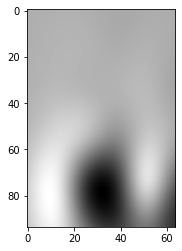

In [18]:
# Visualized the Displacement Field obtained from BSpline Transform

print(field.shape)
import matplotlib.pyplot as plt
plt.imshow(field[15, :, :, 0], cmap='gray')

In [6]:
# Visualize the results after RANSAC ICP

from itkwidgets import view

def readvtk(filename):
    a = vtk.vtkPolyDataReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

def readply(filename):
    a = vtk.vtkPLYReader()
    a.SetFileName(filename)
    a.Update()
    m1 = a.GetOutput()
    return m1

#m1 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174701-Cranium_merged_1.vtk')
m1 = readvtk('fixedMesh.vtk')
#m2 = readvtk('/home/pranjal.sahu/Documents/SampleApeData/USNM174722-Cranium_1.vtk')
m2 = readvtk('ransacICPResult2_b.vtk')
#m3 = readvtk('ransacICPResult2_b_check.vtk')
m3 = readvtk('ransacICPResult2_c_check.vtk')


view(geometries=[m1, m2, m3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [ ]:
# TSD registration

imageDiagonal   = 50
stretchWeight   = 0.0001
bendWeight      = 0.0001
geometricWeight = 0.0001
maxStep         = 1
numOfIterations = 20
learningRate    = 1

movingMesh = itk.meshread('movingMesh.vtk', itk.D)
fixedMesh  = itk.meshread('fixedMesh.vtk', itk.D)

print('Number of Points are')
print(movingMesh.GetNumberOfPoints())
print(fixedMesh.GetNumberOfPoints())

fixedMesh.BuildCellLinks()
movingMesh.BuildCellLinks()

PixelType = itk.D
Dimension = 3

MeshType        = itk.Mesh[itk.D, Dimension]
FixedImageType  = itk.Image[PixelType, Dimension]

# For getting the Bounding Box
ElementIdentifierType = itk.UL
CoordType = itk.F
Dimension = 3

VecContType = itk.VectorContainer[
    ElementIdentifierType, itk.Point[CoordType, Dimension]
]
bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType, VecContType].New()
bounding_box.SetPoints(movingMesh.GetPoints())
bounding_box.ComputeBoundingBox()

minBounds = np.array(bounding_box.GetMinimum())
maxBounds = np.array(bounding_box.GetMaximum())


spacing = np.sqrt(bounding_box.GetDiagonalLength2()) / imageDiagonal
diff = maxBounds - minBounds

print('Spacing ', spacing)
print('minBounds ', minBounds)
print('maxBounds ', maxBounds)

fixedImageSize    = [0]*3
fixedImageSize[0] = math.ceil( 1.2 * diff[0] / spacing )
fixedImageSize[1] = math.ceil( 1.2 * diff[1] / spacing )
fixedImageSize[2] = math.ceil( 1.2 * diff[2] / spacing )

fixedImageOrigin    = [0]*3
fixedImageOrigin[0] = minBounds[0] - 0.1 * diff[0]
fixedImageOrigin[1] = minBounds[1] - 0.1 * diff[1]
fixedImageOrigin[2] = minBounds[2] - 0.1 * diff[2]

fixedImageSpacing   = np.ones(3)*spacing
fixedImageDirection = np.identity(3)


fixedImage = FixedImageType.New()
fixedImage.SetRegions(fixedImageSize)
fixedImage.SetOrigin( fixedImageOrigin )
fixedImage.SetDirection( fixedImageDirection )
fixedImage.SetSpacing( fixedImageSpacing )
fixedImage.Allocate()


# Create BSpline Transformation object and initialize the parameters
SplineOrder = 3
TransformType  = itk.BSplineTransform[itk.D, Dimension, SplineOrder]
InitializerType = itk.BSplineTransformInitializer[TransformType, FixedImageType]

transform = TransformType.New()

# Higher the grid dimensio, slower the computation but higher will be the accuracy
numberOfGridNodesInOneDimension = 8
transformInitializer = InitializerType.New()
transformInitializer.SetTransform(transform)
transformInitializer.SetImage(fixedImage)
transformInitializer.SetTransformDomainMeshSize(numberOfGridNodesInOneDimension - SplineOrder)
transformInitializer.InitializeTransform()



MetricType = itk.ThinShellDemonsMetricv4.MD3
metric = MetricType.New()
metric.SetStretchWeight(stretchWeight)
metric.SetBendWeight(bendWeight)
metric.SetGeometricFeatureWeight(geometricWeight)
metric.UseConfidenceWeightingOn()
metric.UseMaximalDistanceConfidenceSigmaOff()
metric.UpdateFeatureMatchingAtEachIterationOn()
metric.SetMovingTransform(transform)
# Reversed due to using points instead of an image
# to keep semantics the same as in itkThinShellDemonsTest.cxx
# For the ThinShellDemonsMetricv4 the fixed mesh is regularized
metric.SetFixedPointSet(movingMesh)
metric.SetMovingPointSet(fixedMesh)
metric.SetVirtualDomainFromImage(fixedImage)
metric.Initialize()

print('TSD Metric Created')


optimizer = itk.RegularStepGradientDescentOptimizerv4.D.New()
optimizer.SetNumberOfIterations( numOfIterations )
optimizer.SetMaximumStepSizeInPhysicalUnits( maxStep )
optimizer.SetLearningRate(learningRate)
optimizer.SetMinimumConvergenceValue( 0.0 )
optimizer.SetConvergenceWindowSize( numOfIterations )

def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")

iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)


print('Number of Transform Parameters ', transform.GetNumberOfParameters())

AffineRegistrationType = itk.ImageRegistrationMethodv4.REGv4D3D3TD3D3MD3.New()
registration = AffineRegistrationType.New()
registration.SetNumberOfLevels(1)
registration.SetObjectName("registration")
registration.SetFixedPointSet(movingMesh)
registration.SetMovingPointSet(fixedMesh)
registration.SetInitialTransform(transform)
registration.SetMetric(metric)
registration.SetOptimizer(optimizer)
registration.InPlaceOn()

print('Registration Object created')
print('Initial Value of Metric ', metric.GetValue())

try:
    registration.Update()
except e:
    print('Error is ', e)

print('Final Value of TSD Metric ', metric.GetValue())


# Get the Displacement field from the BSpline Transform
finalTransform = registration.GetModifiableTransform()
convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(finalTransform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedMesh)
e_metric.SetMovingPointSet(movingMesh)
print('Euclidean Metric Before TSD Deformable Registration ', e_metric.GetValue())

numberOfPoints = movingMesh.GetNumberOfPoints()
for n in range(0, numberOfPoints):
    movingMesh.SetPoint(n, finalTransform.TransformPoint(movingMesh.GetPoint(n)))

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedMesh)
e_metric.SetMovingPointSet(movingMesh)
print('Euclidean Metric After TSD Deformable Registration ', e_metric.GetValue())

itk.meshwrite(movingMesh, 'result_bspline.vtk')

In [ ]:
# Visualize the fixed mesh, moving mesh and the registered mesh

a = vtk.vtkPolyDataReader()
a.SetFileName('ransacICPResult2.vtk')
a.Update()
m1 = a.GetOutput()

a = vtk.vtkPolyDataReader()
a.SetFileName('result_bspline.vtk')
a.Update()
m2 = a.GetOutput()

a = vtk.vtkPolyDataReader()
a.SetFileName('fixedMesh.vtk')
a.Update()
m3 = a.GetOutput()

itkwidgets.view(geometries=[m1, m2, m3])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [4]:
#finalTransform = registration.GetModifiableTransform()
convertFilter = itk.TransformToDisplacementFieldFilter.IVF33D.New()
convertFilter.SetTransform(final_transform)
convertFilter.UseReferenceImageOn()
convertFilter.SetReferenceImage(fixedImage)
convertFilter.Update()
field = convertFilter.GetOutput()
field = np.array(field)
np.save('displacement_field.npy', field)

NameError: name 'final_transform' is not defined

(24, 48, 29, 3)


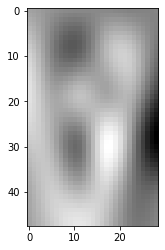

In [36]:
# Visualized the Displacement Field obtained from BSpline Transform

print(field.shape)
import matplotlib.pyplot as plt
plt.imshow(field[15, :, :, 0], cmap='gray')